> TODO:
* Improve embeddings: word2vec, sentence transformers, ...
* Tune params: gridSearch, Optuna ...
* Add regularization or try out other ways to avoid overfitting
* Deploy with Flask

## Import Libraries & Datasets

In [1]:
import os
print(os.listdir("../input"))
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn import metrics

pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titlesize'] = 14
sns.set_style('whitegrid')

from tqdm import tqdm
tqdm.pandas()
from tqdm.notebook import tqdm as tn

import random
import spacy
import re

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from yellowbrick.text import TSNEVisualizer

['twitter-entity-sentiment-analysis']


In [2]:
train_path = '/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv'
valid_path = '/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv'
cols = ['Id', 'Entity', 'Sentiment', 'Tweet']
train = pd.read_csv(train_path, names = cols, header=None)
valid = pd.read_csv(valid_path, names = cols)
# train['is_train'], valid['is_train'] = True, False
all_df = train.append(valid)
all_df["Tweet"] =all_df["Tweet"].str.lower()
all_df =all_df.drop_duplicates().dropna()
all_df.index = range(len(pd.RangeIndex(len(all_df.index))))
all_df

,Id,Entity,Sentiment,Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,i am coming to the borders and i will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
71914,7516,LeagueOfLegends,Neutral,♥️ suikoden 2\n1️⃣ alex kidd in miracle world\...
71915,5708,HomeDepot,Positive,thank you to matching funds home depot rw paym...
71916,2165,CallOfDuty,Neutral,late night stream with the boys! come watch so...
71917,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ toronto is the arts and culture capital of ...


## EDA

In [18]:
labeled_df = train[['Sentiment', 'Tweet']].copy()
labeled_df['label'] = labeled_df.Sentiment.factorize()[0]#0-pos,1-neutr,2-neg
labeled_df['label'] = [int(1) if i==3 else i for i in labeled_df.label.tolist()]
labeled_df['Tweet'] = labeled_df['Tweet'].str.lower()
labeled_df = labeled_df.drop(columns='Sentiment').drop_duplicates().dropna()
labeled_df.drop(labeled_df[(labeled_df['Tweet'].map(len) > 300 )|(labeled_df['Tweet'].map(len) < 10)].index, inplace=True)
labeled_df.label.value_counts()

1    28275
2    20362
0    18346
Name: label, dtype: int64

In [4]:
labeled_valid = valid[['Sentiment', 'Tweet']].copy()
labeled_valid['label'] = labeled_valid.Sentiment.factorize()[0]#0-pos,1-neutr,2-neg
labeled_valid['label'] = [int(1) if i==3 else i for i in labeled_valid.label.tolist()]
labeled_valid['Tweet'] = labeled_valid['Tweet'].str.lower()
labeled_valid = labeled_valid.drop(columns='Sentiment').drop_duplicates().dropna()
labeled_valid.label.value_counts()

1    561
2    265
0    172
Name: label, dtype: int64

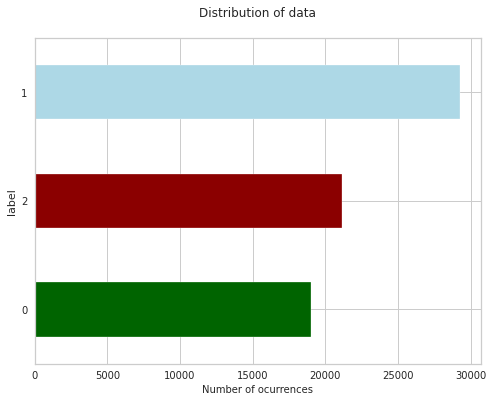

In [5]:
fig = plt.figure(figsize=(8,6))
colors = ['darkgreen', 'darkred', 'lightblue']#0-pos,1-neutr,2-neg
labeled_df.groupby(['label']).Tweet.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'Distribution of data\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [19]:
pos = labeled_df[labeled_df['label']==0].sample(18000, random_state=1).copy()
neg = labeled_df[labeled_df['label']==2].sample(18000, random_state=1).copy()
neu = labeled_df[labeled_df['label']==1].sample(18000, random_state=1).copy()
balanced_df = pos.append(neg).append(neu).reset_index(drop=True)
balanced_df

,Tweet,label
0,what i only want to give tommy & nelson @homed...,0
1,feels nice when you got to transition from sup...,0
2,red dead redemption 2 is the best game to ever...,0
3,fun stuff to be had in overwatch.,0
4,finally finished it; time to go shower and the...,0
...,...,...
53995,good catch! good trumps! they belong with oth...,1
53996,we are sorry that there is no live stream toni...,1
53997,check off my video!,1
53998,"because of comments from a minister like this,...",1


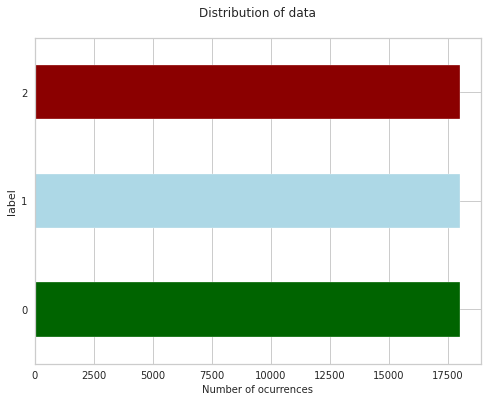

In [21]:
fig = plt.figure(figsize=(8,6))
colors = ['darkgreen','lightblue', 'darkred']#0-pos,1-neutr,2-neg
balanced_df.groupby(['label']).Tweet.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'Distribution of data\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

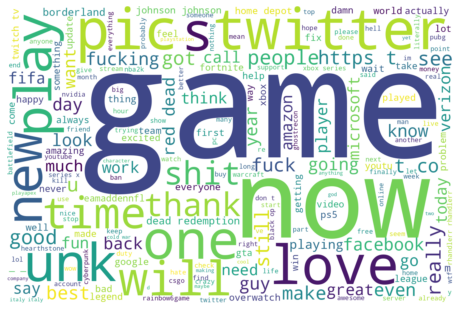

In [8]:
# Generating a word cloud of frequency of text
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", width=1500, height=1000).generate(' '.join(balanced_df['Tweet']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Sentiment Analysis using Long Short Term Memory (LSTM)

LSTM is a type of RNN network that can grasp long term dependence. In RNN, we multiply with the weight associated with the input of the previous state (w1) and weight associated with output for the previous state. And then we pass them to the Tanh function to get the new state. Now to get the output vector we multiply the new state with an output of Tanh function.  RNN suffers from a vanishing gradient problem that is very significant changes in the weights that do not help the model learn. To overcome this LSTM was introduced.
More research on Sentiment Analysis with LSTM RNN could be found in this [article](https://analyticsindiamag.com/how-to-implement-lstm-rnn-network-for-sentiment-analysis/)

In [9]:
y = pd.get_dummies(balanced_df['label']).values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (57000, 3)


Define the LSTM model architecture:
* 3 hyperparameters: 
`MAX_NB_WORDS`, `MAX_SEQUENCE_LENGTH` and `EMBEDDING_DIM`
* `adam` optimizer
* `categorical_crossentropy` loss
* `softmax` activation function
* `SpatialDropout1D` performes dropout

In [10]:
# max num of words to be used
MAX_NB_WORDS =40000
# max number of words in each tweet
MAX_SEQUENCE_LENGTH = 250
# embedding dim
EMBEDDING_DIM = 100

In [11]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(all_df['Tweet'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 34818 unique tokens.


In [12]:
X = tokenizer.texts_to_sequences(balanced_df['Tweet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (57000, 250)


* input layer: uses 100 length vectors to represent each word
* next layer: the LSTM layer with 100 memory units
* output layer: must create 3 output values, one for each class

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.10, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(51300, 250) (51300, 3)
(5700, 250) (5700, 3)


In [16]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))#3
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 2
batch_size = 64

In [17]:
history = model.fit(X_train, y_train, epochs=epochs, 
                    batch_size=batch_size,validation_split=0.1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/2
722/722 [==============================] - 729s 1s/step - loss: 0.7113 - accuracy: 0.6878 - val_loss: 0.4724 - val_accuracy: 0.8172
Epoch 2/2
722/722 [==============================] - 742s 1s/step - loss: 0.3296 - accuracy: 0.8762 - val_loss: 0.3495 - val_accuracy: 0.8690


## Evaluation

In [22]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

179/179 [==============================] - 34s 186ms/step - loss: 0.3526 - accuracy: 0.8686
Test set
  Loss: 0.353
  Accuracy: 0.869


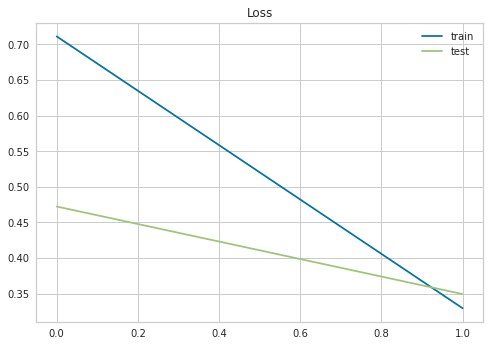

In [23]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

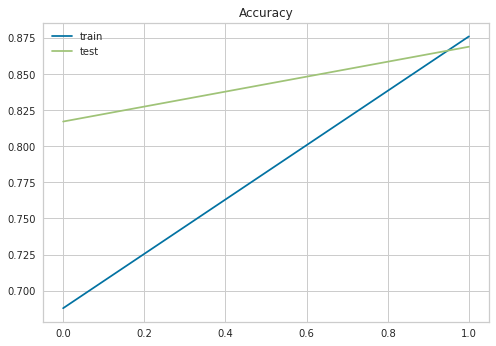

In [38]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

Test with new tweet

In [85]:
def predict_sent(tweet):
    seq = tokenizer.texts_to_sequences(tweet)
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    pred = model.predict(padded)
    labels = ['Positive','Neutral','Negative']
    return pred, labels[np.argmax(pred)]

In [86]:
print(predict_sent(['I love the way they showed up yesterday']))
print(predict_sent(['run out of food, going out for pizza']))
print(predict_sent(['The worst show I\'ve ever seen']))

(array([[0.4932157 , 0.47167137, 0.03511292]], dtype=float32), 'Positive')
(array([[0.09777137, 0.33598438, 0.56624424]], dtype=float32), 'Negative')
(array([[0.09328368, 0.2494166 , 0.65729976]], dtype=float32), 'Negative')


In [88]:
labeled_valid['label_pred'] = labeled_valid['Tweet'].progress_apply(lambda x:predict_sent([x]))

100%|██████████| 998/998 [02:24<00:00,  6.89it/s]


In [91]:
labels_dict = {'Positive':0,'Neutral':1,'Negative': 2}
labeled_valid['pred'] = labeled_valid['label_pred'].apply(lambda x: labels_dict[x[1]])
labeled_valid

,Tweet,label,label_pred,pred
0,i mentioned on facebook that i was struggling ...,0,"([[0.0026807657, 0.99310404, 0.004215205]], Ne...",1
1,bbc news - amazon boss jeff bezos rejects clai...,1,"([[0.00040635563, 0.99597126, 0.0036223005]], ...",1
2,@microsoft why do i pay for word when it funct...,2,"([[0.0014481867, 0.0049673133, 0.99358445]], N...",2
3,"csgo matchmaking is so full of closet hacking,...",2,"([[0.00047554966, 0.0042640725, 0.9952604]], N...",2
4,now the president is slapping americans in the...,1,"([[0.00054574787, 0.9986461, 0.0008081619]], N...",1
...,...,...,...,...
995,⭐️ toronto is the arts and culture capital of ...,0,"([[0.0009897603, 0.9988444, 0.00016591385]], N...",1
996,this is actually a good move tot bring more vi...,0,"([[0.018641273, 0.9791932, 0.002165587]], Neut...",1
997,today sucked so it’s time to drink wine n play...,1,"([[0.8818874, 0.109744936, 0.00836762]], Posit...",0
998,bought a fraction of microsoft today. small wins.,1,"([[0.98454094, 0.012465172, 0.002993882]], Pos...",0


## Evaluate

In [93]:
from sklearn.metrics import accuracy_score
accuracy_score(labeled_valid['label'].tolist(), labeled_valid['pred'].tolist())

0.5400801603206413

In [94]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(labeled_valid['label'].tolist(), labeled_valid['pred'].tolist(), target_names=['Positive','Neutral','Negative']))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

    Positive       0.03      0.05      0.04       172
     Neutral       0.63      0.50      0.56       561
    Negative       0.92      0.95      0.93       265

    accuracy                           0.54       998
   macro avg       0.53      0.50      0.51       998
weighted avg       0.60      0.54      0.57       998



## Confusion Matrix

In [96]:
!git clone https://github.com/DTrimarchi10/confusion_matrix

fatal: destination path 'confusion_matrix' already exists and is not an empty directory.


In [97]:
url = f"https://raw.githubusercontent.com/DTrimarchi10/confusion_matrix/master/cf_matrix.py"
!wget --no-cache --backups=1 {url}
import subprocess
result = subprocess.run(["wget", "--no-cache", "--backups=1", url], stderr=subprocess.PIPE, stdout=subprocess.PIPE)
print(result.stderr.decode("utf-8"))

--2022-05-19 12:41:11--  https://raw.githubusercontent.com/DTrimarchi10/confusion_matrix/master/cf_matrix.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4088 (4.0K) [text/plain]
Failed to rename cf_matrix.py to cf_matrix.py.1: (2) No such file or directory
Saving to: ‘cf_matrix.py’

cf_matrix.py        100%[===================>]   3.99K  --.-KB/s    in 0s      

2022-05-19 12:41:11 (42.7 MB/s) - ‘cf_matrix.py’ saved [4088/4088]

--2022-05-19 12:41:11--  https://raw.githubusercontent.com/DTrimarchi10/confusion_matrix/master/cf_matrix.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connecte

In [98]:
from cf_matrix import make_confusion_matrix
sns.set_context('talk')

In [99]:
conf_mat = confusion_matrix(labeled_valid['label'].tolist(), labeled_valid['pred'].tolist())
conf_mat

array([[  8, 156,   8],
       [267, 280,  14],
       [  6,   8, 251]])

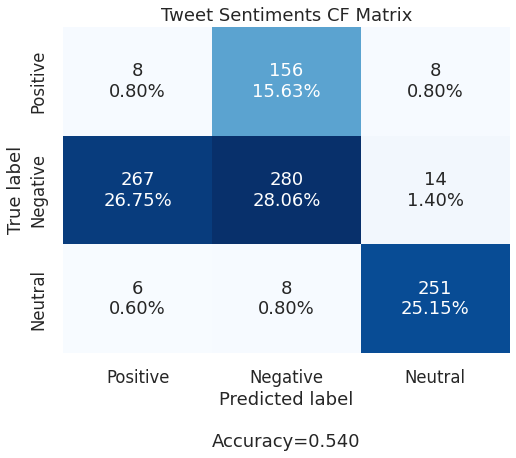

In [100]:
categories = ['Positive','Negative', 'Neutral']
make_confusion_matrix(conf_mat, figsize=(8,6), cbar=False,categories = categories, title='Tweet Sentiments CF Matrix')